# VR Mini Project - Binary Classification Tasks

## Part A - Binary Classification Using 2 models- Neural Network and Support Vector Machine

In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [10]:
# Function to extract HOG features from an image
def extract_hog(image):
    # Convert image to grayscale and resize for uniformity
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, (64, 64))
    
    # Compute HOG features
    hog_features, _ = hog(resized_image,pixels_per_cell=(8, 8),cells_per_block=(2, 2),
        orientations=9,block_norm='L2-Hys',visualize=True)
    return hog_features


In [11]:
# Function to load the dataset and extract features
def load_data(data_path):
    X = []
    y = []
    classes = ['with_mask', 'without_mask']
    
    for class_idx, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        print(f"Processing images in '{class_name}' folder...")
        
        for image_file in tqdm(os.listdir(class_folder)):
            image_path = os.path.join(class_folder, image_file)
            image = cv2.imread(image_path)
            
            if image is not None:
                # Extract HOG features
                hog_features = extract_hog(image)
                X.append(hog_features)
                y.append(class_idx)
    
    return np.array(X), np.array(y)

In [12]:
# Load dataset
dataset_path = "./dataset/dataset1"  # Replace with the path to your dataset
X, y = load_data(dataset_path)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Processing images in 'with_mask' folder...


100%|██████████| 2165/2165 [00:27<00:00, 80.03it/s]


Processing images in 'without_mask' folder...


100%|██████████| 1931/1931 [00:19<00:00, 97.83it/s] 


In [17]:
# param_dist = {
#     'C': uniform(0.1, 100),
#     'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
#     'gamma': ['scale', 'auto']
# }
# random_search = RandomizedSearchCV(SVC(), param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1)
# random_search.fit(X_train, y_train)
# best_svm = random_search.best_estimator_

# The SVM below contains the best parameters after running RandomizedSearch on the param_grid above. I have commented it out since it takes around 7 min to run.
best_svm = SVC(C=53.07, gamma='scale', kernel='rbf')  
best_svm.fit(X_train,y_train)
y_pred_svm = best_svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

# print(f"Best SVM Parameters: {random_search.best_params_}")


In [18]:
# Define parameter distributions
# param_dist = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 50)],
#     'activation': ['relu', 'tanh', 'logistic'],
#     'solver': ['adam', 'sgd'],
#     'alpha': [0.0001, 0.001, 0.01],  # Regularization term
#     'learning_rate': ['constant', 'adaptive']
# }
# Initialize Randomized Search
# random_search = RandomizedSearchCV(MLPClassifier(max_iter=500), param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1)
# random_search.fit(X_train, y_train)


# # Get best model
# best_nn = random_search.best_estimator_

# The neural network below contains the best parameters after running RandomizedSearch on the param_grid above. I have commented it out since it takes around 20 min to run.
best_nn = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(100, 50, 50), alpha=0.01, activation='relu', max_iter=500,random_state=42)
best_nn.fit(X_train,y_train)
# Evaluate on test data
y_pred_nn = best_nn.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred_nn)

# print(f"Best Neural Network Parameters: {random_search.best_params_}")
print(f"SVM Accuracy after tuning: {svm_accuracy:.2f}")
print(f"Neural Network Accuracy after tuning: {nn_accuracy:.2f}")


SVM Accuracy after tuning: 0.94
Neural Network Accuracy after tuning: 0.93


## Part B - Binary Classification Using CNN(Convolutional Neural Network)

In [20]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt

# Dataset configuration
data_directory = "./dataset/dataset1"
input_image_size = (64, 64)

# Image augmentation and data preparation
image_generator = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

# Function to load datasets
def create_data_generators(batch_size):
    train_data = image_generator.flow_from_directory(
        data_directory,
        target_size=input_image_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training'
    )

    validation_data = image_generator.flow_from_directory(
        data_directory,
        target_size=input_image_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )
    return train_data, validation_data

# # Hypermodel definition for Keras Tuner (Hyperparameter tuning)
# def build_cnn_model(hp):
#     model = Sequential([
#         Conv2D(hp.Choice('conv1_filters', [32, 64]), (3, 3),
#                activation=hp.Choice('activation', ['relu', 'tanh']),
#                input_shape=(64, 64, 3)),
#         MaxPooling2D(2, 2),
#         Conv2D(hp.Choice('conv2_filters', [64, 128]), (3, 3),
#                activation=hp.Choice('activation', ['relu', 'tanh'])),
#         MaxPooling2D(2, 2),
#         Flatten(),
#         Dense(hp.Int('dense_units', 64, 256, step=64),
#               activation=hp.Choice('activation', ['relu', 'tanh'])),
#         Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)),
#         Dense(1, activation='sigmoid')
#     ])

#     optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
#     learning_rate = hp.Choice('learning_rate', [0.001, 0.0005])

#     if optimizer == 'adam':
#         optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
#     elif optimizer == 'sgd':
#         optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
#     elif optimizer == 'rmsprop':
#         optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     return model



# # Keras Tuner - Random Search
# random_search = kt.RandomSearch(
#     hypermodel=build_cnn_model,
#     objective='val_accuracy',
#     max_trials=10,  # Number of different hyperparameter combinations
#     executions_per_trial=1,  # Number of models trained per trial
#     directory='hyperparam_search',
#     project_name='cnn_random_search'
# )

# # Run the search
# random_search.search(train_gen, validation_data=val_gen, epochs=5, verbose=1)

# # Get the best model
# best_model = random_search.get_best_models(num_models=1)[0]

# The CNN below contains the best parameters after hyperparameter tuning commented out above. 
# I have commented it out since it takes around 10 min to run.

# Create data generators
batch_size = 32
train_gen, val_gen = create_data_generators(batch_size)
best_cnn_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
# Compile model with best optimizer and learning rate
opt = keras.optimizers.RMSprop(learning_rate=0.001)
best_cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_history = best_cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    batch_size=batch_size,
    verbose=1
)

# Evaluate the model and print the accuracy
loss, accuracy = best_cnn_model.evaluate(val_gen)
print(f"Final Validation Accuracy: {accuracy:.2f}")


Found 3274 images belonging to 2 classes.
Found 818 images belonging to 2 classes.
Epoch 1/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.6824 - loss: 0.9511 - val_accuracy: 0.9352 - val_loss: 0.2189
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.8700 - loss: 0.3155 - val_accuracy: 0.9364 - val_loss: 0.1636
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.9080 - loss: 0.2315 - val_accuracy: 0.9645 - val_loss: 0.0997
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9407 - loss: 0.1618 - val_accuracy: 0.9597 - val_loss: 0.1196
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.9487 - loss: 0.1451 - val_accuracy: 0.9719 - val_loss: 0.0708
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9808 - loss: 0.0570
Final Validation Accuracy: 0.97


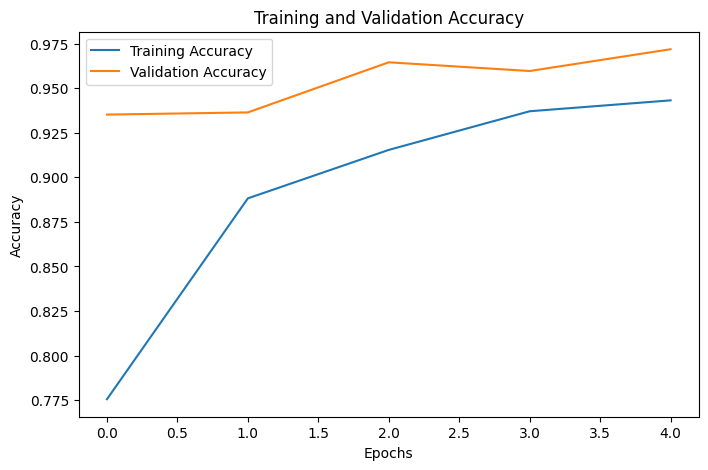

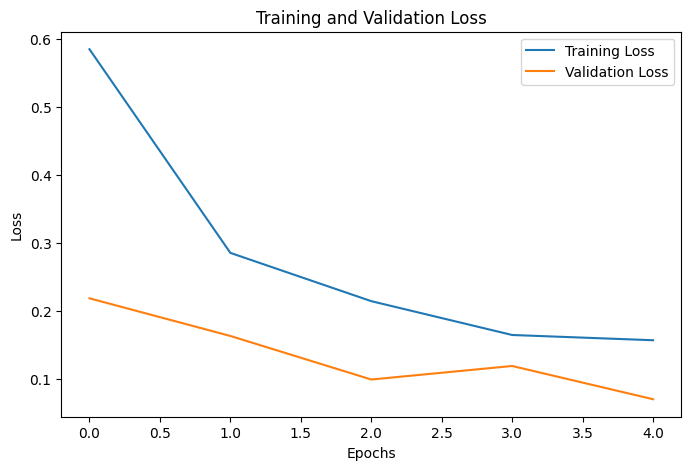

In [21]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()